# Imports

In [1]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  Exception('Error Initialising Iminuit')

In [2]:
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

# Funcs

In [3]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [4]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [5]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [6]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Data

In [7]:
data = 'https://docs.google.com/spreadsheets/d/10J8iO8non_Iq_K_8JXAtarPfYMNR1pZCf4Qn8pPsk_4/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['RC', 'RL', 'RLC_sovra', 'RLC_sotto', 'RLC_crit'])


# RC

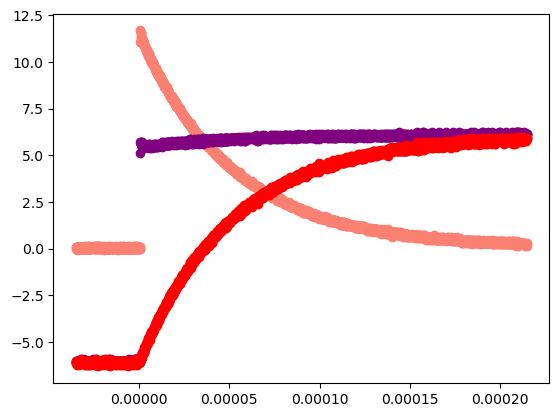

In [57]:
RC_quadra = pd.read_csv('data/RC_1kohm/F0007CH1.CSV')
RC_data = pd.read_csv('data/RC_1kohm/F0007CH2.CSV')
RC_math = pd.read_csv('data/RC_1kohm/F0007MTH.CSV')

plt.title('RC 1kohm')
plt.scatter(RC_data[RC_data.keys()[3]],RC_data[RC_data.keys()[4]],c='salmon')
plt.scatter(RC_quadra[RC_quadra.keys()[3]],RC_quadra[RC_quadra.keys()[4]], c='purple')
plt.scatter(RC_math[RC_math.keys()[3]],RC_math[RC_math.keys()[4]], c='red')

In [22]:
def V_RC(t,V_o,R,C,T, offset):
    if V_o >0:
        return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )
    else:
        return V_o*( 1 - 2*(np.exp(- ((t+offset)-(T/2)) /(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

0.48
358


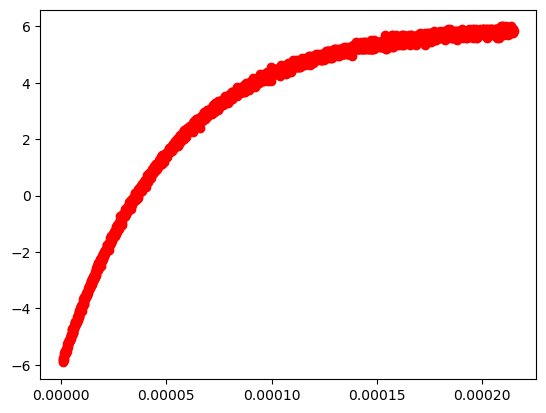

In [58]:
i=0
v=RC_data[RC_data.keys()[4]][2100]
print(v)
while(v<np.max(RC_data[RC_data.keys()[4]])):
    v=RC_data[RC_data.keys()[4]][i]
    i+=1
print(i)

plt.scatter((RC_math[RC_math.keys()[3]])[i:],(RC_math[RC_math.keys()[4]])[i:], c='red')

In [59]:
t1,t2 = np.min(RC_data[RC_data.keys()[3]]),np.max(RC_data[RC_data.keys()[3]])
vmin = np.min(RC_data[RC_data.keys()[4]])
t1,t2,vmin

(-3.49e-05, 0.0002149, -0.08)

In [68]:
c = LeastSquares(RC_math[RC_math.keys()[3]][i:],RC_math[RC_math.keys()[4]][i:], .01, V_RC)
m = Minuit(c, R=1000,V_o=6, C=49*1e-9, T=1, offset=0)
m.fixed['T']=True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.297e+05 (χ²/ndof = 60.7) │              Nfcn = 141              │
│ EDM = 8.58e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  6.0315   │  0.0005   │            │            │         │         │       │
│ 1 │ R      │ 1.0239e3  │ 0.0010e3  │            │            │         │         │       │
│ 2 │ C      │ 50.17e-9  │  0.05e-9  │            │            │         │         │       │
│ 3 │ T      │   1.00    │   0.01    │            │            │         │         │  yes  │
│ 4 │ offset │  -87e-9   │   6e-9    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │                V_o                  R                  C                  T             offset │
├────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│    V_o │            2.6e-07           38.90e-6      1.9059655e-15                  0       2.000838e-12 │
│      R │           38.90e-6               0.99 -47.6421913507e-12                  0     449.328492e-12 │
│      C │      1.9059655e-15 -47.6421913507e-12           2.38e-21                  0           22.0e-21 │
│      T │                  0                  0                  0                  0                  0 │
│ offset │       2.000838e-12     449.328492e-12           22.0e-21                  0           3.04e-17 │
└────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

# RL

In [61]:
def V_RL(t,V_o,R,L,T):
    if V_o > 0:
        return V_o* 2*(np.exp(-t*R/L) / (1 + np.exp( -T*R/L) ) )
    else:
        return V_o* 2*(np.exp(-(t-(T/2))*R/L) / (1 + np.exp( -T*R/L) ) )

In [121]:
def V_RL_2(t,V_o,tau,c):
    return V_o*(np.exp(-t/tau))+c

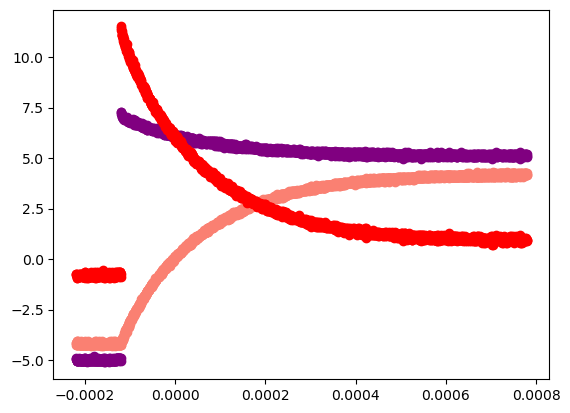

In [93]:
RL_quadra = pd.read_csv('data/RL_200ohm/F0002CH1.CSV')
RL_data = pd.read_csv('data/RL_200ohm/F0002CH2.CSV')
RL_ind_v = RL_quadra[RL_quadra.keys()[4]] - RL_data[RL_data.keys()[4]]

plt.scatter(RL_data[RL_data.keys()[3]],RL_data[RL_data.keys()[4]],c='salmon')
plt.scatter(RL_quadra[RL_quadra.keys()[3]],RL_quadra[RL_quadra.keys()[4]], c='purple')
plt.scatter(RL_data[RL_data.keys()[3]],RL_ind_v, c='red')

250


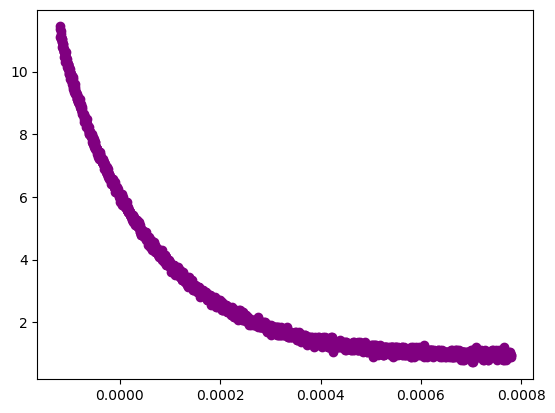

In [106]:
i=0
v=RL_ind_v[0]

while(v < np.max(RL_ind_v)):
    v=RL_ind_v[i]
    i+=1
plt.scatter((RL_quadra[RL_quadra.keys()[3]])[i:],(RL_ind_v)[i:], c='purple')
print(i)

In [111]:
1/42

0.023809523809523808

In [120]:
np.min(RL_ind_v[i:])

0.7199999999999998

In [122]:
c = LeastSquares(RL_data[RL_data.keys()[3]][i:],RL_ind_v[i:], .1, V_RL_2)
m = Minuit(c, tau = 1e-4,V_o=8, c=0.7)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1365 (χ²/ndof = 0.6)       │              Nfcn = 122              │
│ EDM = 3.01e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │   5.178   │   0.007   │            │            │         │         │       │
│ 1 │ tau  │ 177.4e-6  │  0.4e-6   │            │            │         │         │       │
│ 2 │ c    │   0.858   │   0.004   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────┐
│     │         V_o         tau           c │
├─────┼─────────────────────────────────────┤
│ V_o │    4.33e-05  1.74394e-9   -0.022e-3 │
│ tau │  1.74394e-9    1.26e-13 -1.08578e-9 │
│   c │   -0.022e-3 -1.08578e-9    1.66e-05 │
└─────┴─────────────────────────────────────┘

In [131]:
tau = m.values['tau']
R = 200+39
L = tau*R
print('Induttanza:',L)

Induttanza: 0.04239793657283182


# RLC sottosmorzato

In [62]:
def V_RLC_st(t,V_o,R,L,C):
    '''tensione in regime sottosmorzato'''
    betha = np.sqrt( (1/(L*C))**2 - (R/L)**2 )
    return V_o*np.exp(-t*R/L)*np.sin(t*betha)

# RLC sovrasmorzato 

In [63]:
def V_RLC_sv(t,V_o,R,L,C):
    '''tensione in regime sovrasmorzato'''
    betha = np.sqrt( (R/L)**2 - (1/(L*C))**2 )
    return V_o*np.exp(-t*R/L)*[np.exp(t*betha) - np.exp(-t*betha)]

# RLC critico

In [64]:
def V_RLC_crt(t,V_o,R,L,C):
    '''tensione in regime critico'''
    return V_o*t*np.exp(-t*R/L)